This notebook demonstrates a usage of a pre-trained SpeakerBeam model. Before running the notebook, follow the instructions in README to:
* install all necessary requirements
* set the path to the repository in `path.sh` script
* run `. path.sh` before running the notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import torch
import random
import IPython.display as dsp
import soundfile as sf
from asteroid.metrics import get_metrics
import pandas as pd

from models.td_speakerbeam import TimeDomainSpeakerBeam

## Loading the model

The example model in `pretrained_model` was train on `train_100` subset of Libri2Mix for separating noisy mixtures (task `sep_noisy`). 

In [2]:
modelpath = '../example/model.pth'

In [3]:
model = TimeDomainSpeakerBeam.from_pretrained(modelpath)

## Loading the data

In [4]:
mix,fs = sf.read('../example/mixture.wav')
enroll,fs = sf.read('../example/enrollment.wav')
source,fs = sf.read('../example/source.wav')

In [5]:
mix = torch.from_numpy(mix).float()
enroll = torch.from_numpy(enroll).float()

## Inference

In [6]:
torch.no_grad().__enter__()

In [7]:
est_source = model(mix.unsqueeze(0), enroll.unsqueeze(0))[0][0].detach()

In [8]:
sf.write('est_output.wav', est_source.numpy() / est_source.numpy().max(), 8000)

In [9]:
print('Mixture')
dsp.display(dsp.Audio(mix.numpy(), rate=8000))
print('Enrollment utterance')
dsp.display(dsp.Audio(enroll.numpy(), rate=8000))
print('Estimated target speaker')
dsp.display(dsp.Audio(est_source.numpy(), rate=8000))
print('Reference target speaker')
dsp.display(dsp.Audio(source, rate=8000))

Mixture


Enrollment utterance


Estimated target speaker


Reference target speaker


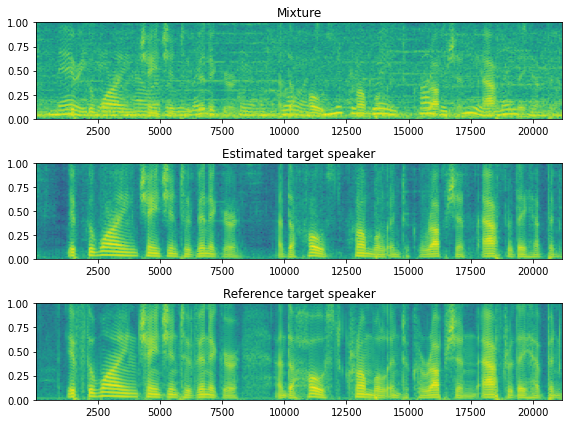

In [10]:
fig, ax = plt.subplots(3, figsize=(8,6))
ax[0].specgram(mix.numpy())
ax[0].set_title('Mixture')
ax[1].specgram(est_source.numpy())
ax[1].set_title('Estimated target speaker')
ax[2].specgram(source)
ax[2].set_title('Reference target speaker')
plt.tight_layout()
plt.show()

## Evaluation

In [11]:
all_results = get_metrics(mix.numpy(), source, est_source.numpy(), sample_rate=8000)

In [12]:
# Pretty printing of the results
metrics = [m for m in all_results if not m.startswith('input') and 'sir' not in m]
data = pd.DataFrame([[m, all_results[f'input_{m}'], all_results[m]] for m in metrics],
                    columns=['metric', 'input', 'output'])
dsp.display(dsp.HTML(data.to_html(index=False)))

metric,input,output
si_sdr,-3.809231,12.389843
sdr,-3.572491,12.765608
sar,-3.572491,12.765608
stoi,0.658744,0.924465
pesq,1.562157,2.695283
